# Daffa Bima Perdana
# 09011281823057
# SK5B Indralaya

Sumber = https://www.kaggle.com/ozdemirh/diabetes-prediction-with-artificial-neural-network

MLP (Multi Layer Perceptron) Classifier adalah implementasi jaringan saraf buatan feedforward dari perpustakaan Scikit-Learn.

MLPClassifier digunakan untuk memprediksi apakah pasien menderita diabetes berdasarkan serangkaian diagnostik.

Kerangka pekerjaan adalah sebagai berikut:

* Load Data
* Split Data
* Visualization and Outlier Check
* Standardization
* Correlation Analysis
* Feature Importance
* Train MLP
* Test MLP

In [1]:
import numpy as np
import itertools
import os
import pandas as pd
import seaborn as sea

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFE

import xgboost as xgb
from xgboost import plot_importance

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
sea.set_style("darkgrid")

## Load Data


Datased Pima Indians Diabetes yang digunakan.

In [3]:
data = pd.read_csv("/Users\Lenovo\Downloads\Diabetes ANN\input/"
                   "diabetes.csv")

data.head(10).style.set_precision(2). \
                    set_properties(**{"min-width": "60px"}). \
                    set_properties(**{"color": "#111111"}). \
                    set_properties(**{"text-align": "center"}). \
                    set_table_styles([
                          {"selector": "th",
                           "props": [("font-weight", "bold"),
                                     ("font-size", "12px"),
                                     ("text-align", "center")]},
                          {"selector": "tr:nth-child(even)",
                           "props": [("background-color", "#f2f2f2")]},
                          {"selector": "tr:nth-child(odd)",
                           "props": [("background-color", "#fdfdfd")]},
                          {"selector": "tr:hover",
                           "props": [("background-color", "#bcbcbc")]}])

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.60,0.63,50,1
1,1,85,66,29,0,26.60,0.35,31,0
2,8,183,64,0,0,23.30,0.67,32,1
3,1,89,66,23,94,28.10,0.17,21,0
4,0,137,40,35,168,43.10,2.29,33,1
5,5,116,74,0,0,25.60,0.20,30,0
6,3,78,50,32,88,31.00,0.25,26,1
7,10,115,0,0,0,35.30,0.13,29,0
8,2,197,70,45,543,30.50,0.16,53,1
9,8,125,96,0,0,0.00,0.23,54,1


Ada 8 fitur dan outcome pada variabel target.

* Pregnancies
* Glucose
* BloodPressure
* SkinThickness
* Insulin
* BMI (Body mass index)
* DiabetesPedigreeFunction
* Age


Fitur ditetapkan ke label data_X dan terkait dengan data_Y. Info panda memperlihatkan tipe data kolom (fitur) dan jumlah nilai bukan nol.

In [4]:
# disable SettingWithCopyWarning messages
pd.options.mode.chained_assignment = None

data_X = data.loc[:, data.columns != "Outcome"]
data_Y = data[["Outcome"]]

print("data_X info:\n")
data_X.info()
print("\ndata_Y info:\n")
data_Y.info()

data_X info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 48.1 KB

data_Y info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Outcome  768 non-null    int64
dtypes: int64(1)
memory usage: 6.1 KB


Set data memiliki 768 baris (sampel pelatihan). Semua fitur adalah numerik. Dan tampaknya tidak ada nilai yang hilang. Di sini, satu poin membutuhkan perhatian ekstra. Di set data Anda, nilai yang hilang dapat dikodekan selain **NaN** atau **NA**. Misalnya, jika Anda pergi dan mengubah beberapa sel dalam set data menjadi **Na** atau **NAN** dan memuatnya lagi dan memeriksa info, **Pandas** tidak akan mengenalinya sebagai nilai kosong. Jadi, ** Pandas ** mungkin tidak mendeteksi sel-sel ini sebagai hilang. Dalam kasus kami, set data kecil dan inspeksi visual singkat mengungkapkan tidak ada nilai yang hilang. Tapi ada poin lain. Beberapa sel mungkin dikodekan dengan input yang tidak mungkin. Misalnya, 0 mungkin menunjukkan nilai yang hilang untuk fitur numerik. 

Nomor kelas dan distribusinya diperiksa di bawah cell.

In [5]:
data_Y["Outcome"].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

Terdapat dua kelas yang tersedia, pasien yang terkena diabetes dan pasien yang tidak terkena diabetes.

## Split Data

Kumpulan data dibagi menjadi train dan test set. Lalu menggunakan parameter stratify dari train_test_split untuk mendapatkan distribusi kelas yang sama di seluruh train dan test set.

In [6]:
train_X, test_X, train_Y, test_Y = train_test_split(data_X, data_Y,
                                                    test_size=0.2,
                                                    stratify=data_Y,
                                                    random_state=0)

train_X.reset_index(drop=True, inplace=True);
test_X.reset_index(drop=True, inplace=True);
train_Y.reset_index(drop=True, inplace=True);
test_Y.reset_index(drop=True, inplace=True);

## Visualization and Outlier Check


Outlier menurunkan kinerja pembelajaran. Analisis outlier dilakukan untuk setiap fitur satu per satu. Kami menggunakan analisis kuartil untuk deteksi luar. Untuk setiap fitur, ada dua plot di bawah ini. Distribusi fitur ada di sebelah kiri. Plot kotak dengan fitur yang sama ada di sebelah kanan. Keduanya dianalisis bersama untuk mendapatkan gambaran tentang outlier. Mulai saat ini, kumis bawah boxplot ditandai sebagai LW dan kumis atas ditandai sebagai UW.

Untuk menggambar boxplot, data fitur dibagi menjadi empat. Diperlukan tiga titik potong. Titik-titik ini adalah kuartil yang lebih rendah (atau kuartil pertama), median (atau kuartil kedua) dan kuartil atas (atau kuartil ketiga). Kuartil pertama adalah median data yang lebih rendah dari kuartil kedua. Kuartil ketiga adalah median data yang lebih besar dari kuartil kedua. Interquartile range (IQR) ditemukan mengurangi kuartil yang lebih rendah dari kuartil atas. Outlier ditentukan menggunakan kuartil atas dan IQR yang lebih rendah.


In [7]:
def plots(feature):
    fig = plt.figure(constrained_layout = True, figsize=(10,3))
    gs = gridspec.GridSpec(nrows=1, ncols=4, figure=fig)

    ax1 = fig.add_subplot(gs[0,:3])    
    sea.distplot(train_X.loc[train_Y["Outcome"]==0,feature],
                 kde = False, color = "#004a4d", norm_hist=False,
                 hist_kws = dict(alpha=0.8), bins=40,
                 label="Not Diabetes", ax=ax1);
    sea.distplot(train_X.loc[train_Y["Outcome"]==1,feature],
                 kde = False, color = "#7d0101", norm_hist=False,
                 hist_kws = dict(alpha=0.6), bins=40,
                 label="Diabetes", ax=ax1);
    ax2 = fig.add_subplot(gs[0,3])    
    sea.boxplot(train_X[feature], orient="v", color = "#989100",
                width = 0.2, ax=ax2);
    
    ax1.legend(loc="upper right");

### Feature 0 - Pregnancies

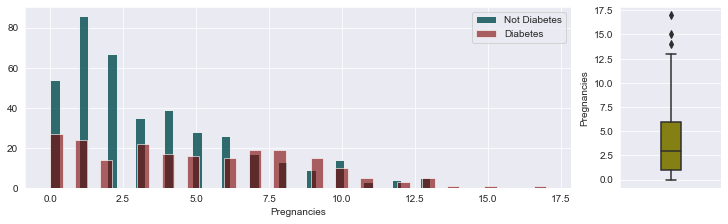

In [8]:
plots("Pregnancies")

Untuk fitur Pregnancies, ada beberapa pengukuran di atas kumis atas. Ini adalah peristiwa langka. Kami menggantinya dengan kuantil ke-95.

In [9]:
Q1 = train_X["Pregnancies"].quantile(0.25)
Q3 = train_X["Pregnancies"].quantile(0.75)
q95th = train_X["Pregnancies"].quantile(0.95)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR

train_X["Pregnancies"] = np.where(train_X["Pregnancies"] > UW,
                                  q95th, train_X["Pregnancies"])

### Feature 1 - Glucose

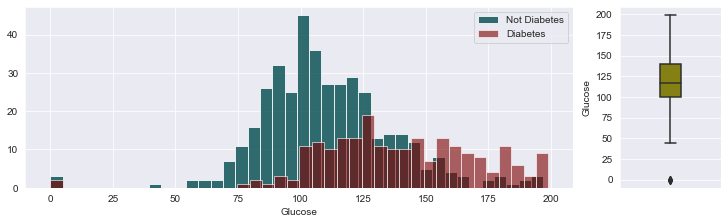

In [10]:
plots("Glucose")

Ada beberapa nilai 0 untuk **Glukosa**. Kita dapat menganggap nilai 0 sebagai tempat penampung untuk data yang hilang. Jadi kami menggantinya dengan median.

In [11]:
med = train_X["Glucose"].median()
train_X["Glucose"] = np.where(train_X["Glucose"] == 0, med, train_X["Glucose"])

### Feature 2 - BloodPressure

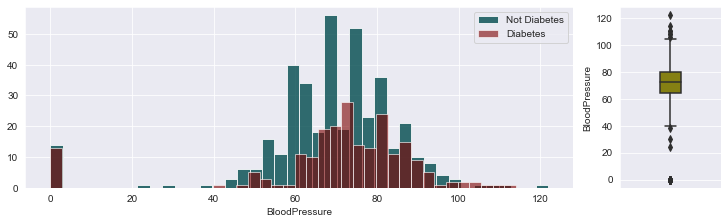

In [12]:
plots("BloodPressure")

Ada beberapa nilai 0 untuk **BloodPressure** yang tidak mungkin. Jadi kami menggantinya dengan median. Selain itu, kami mengganti nilai yang lebih rendah dari LW (kecuali nol) dengan kuantitasi ke-5 dan mengganti nilai yang lebih besar dari UW dengan kuantitasi ke-95.

In [13]:
med = train_X["BloodPressure"].median()
q5th = train_X["BloodPressure"].quantile(0.05)
q95th = train_X["BloodPressure"].quantile(0.95)
Q1 = train_X["BloodPressure"].quantile(0.25)
Q3 = train_X["BloodPressure"].quantile(0.75)
IQR = Q3 - Q1
LW = Q1 - 1.5*IQR
UW = Q3 + 1.5*IQR

train_X["BloodPressure"] = np.where(train_X["BloodPressure"] == 0,
                                    med, train_X["BloodPressure"])
train_X["BloodPressure"] = np.where(train_X["BloodPressure"] < LW,
                                    q5th, train_X["BloodPressure"])
train_X["BloodPressure"] = np.where(train_X["BloodPressure"] > UW,
                                    q95th, train_X["BloodPressure"])

### Feature 3 - SkinThickness

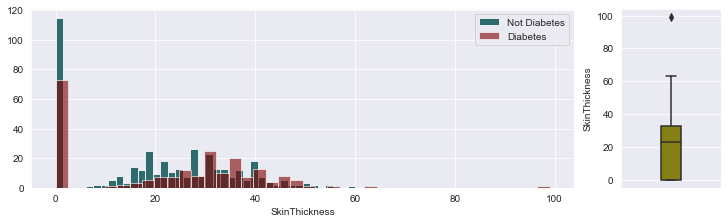

In [14]:
plots("SkinThickness")

Ada beberapa nilai 0 untuk **SkinThickness** yang tidak mungkin. Jadi kami menggantinya dengan median. Juga, kami mengganti nilai yang lebih besar dari UW dengan kuantitasi ke-95.

In [15]:
med = train_X["SkinThickness"].median()
q95th = train_X["SkinThickness"].quantile(0.95)
Q1 = train_X["SkinThickness"].quantile(0.25)
Q3 = train_X["SkinThickness"].quantile(0.75)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR

train_X["SkinThickness"] = np.where(train_X["SkinThickness"] == 0,
                                    med, train_X["SkinThickness"])
train_X["SkinThickness"] = np.where(train_X["SkinThickness"] > UW,
                                    q95th, train_X["SkinThickness"])

### Feature 4 - Insulin

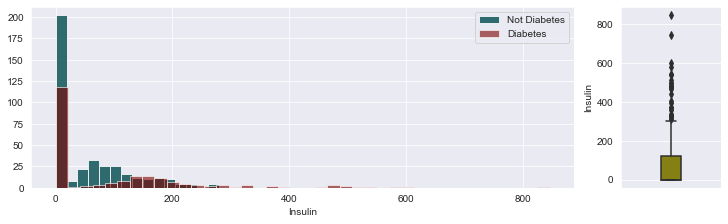

In [16]:
plots("Insulin")

Ada beberapa nilai 0 untuk **Insulin** yang tidak mungkin. Jadi kita ganti dengan median becuse kuantitasi ke-60 adalah 0. Juga, kami mengganti nilai yang lebih besar dari UW dengan kuantitasi ke-95.

In [17]:
q60th = train_X["Insulin"].quantile(0.60)
q95th = train_X["Insulin"].quantile(0.95)
Q1 = train_X["Insulin"].quantile(0.25)
Q3 = train_X["Insulin"].quantile(0.75)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR

train_X["Insulin"] = np.where(train_X["Insulin"] == 0,
                              q60th, train_X["Insulin"])
train_X["Insulin"] = np.where(train_X["Insulin"] > UW,
                              q95th, train_X["Insulin"])

### Feature 5 - BMI

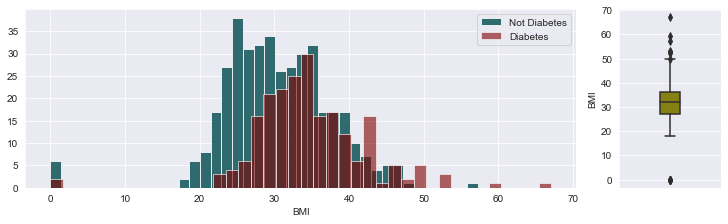

In [18]:
plots("BMI")

Ada beberapa nilai 0 untuk **BMI**. Kami menggantinya dengan median. Juga, kami mengganti nilai yang lebih besar dari UW dengan q95th.

In [19]:
med = train_X["BMI"].median()
q95th = train_X["BMI"].quantile(0.95)
Q1 = train_X["BMI"].quantile(0.25)
Q3 = train_X["BMI"].quantile(0.75)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR

train_X["BMI"] = np.where(train_X["BMI"] == 0,
                          med, train_X["BMI"])
train_X["BMI"] = np.where(train_X["BMI"] > UW,
                          q95th, train_X["BMI"])

### Feature 6 - DiabetesPedigreeFunction

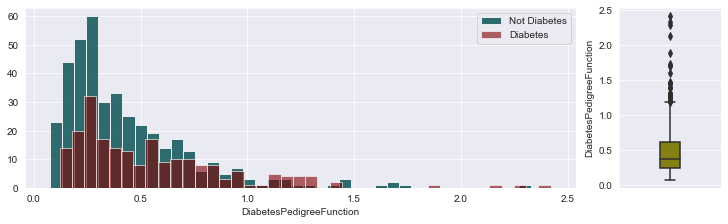

In [20]:
plots("DiabetesPedigreeFunction")

Kami mengganti nilai yang lebih besar dari UW dengan kuantitasi ke-95.

In [21]:
q95th = train_X["DiabetesPedigreeFunction"].quantile(0.95)
Q1 = train_X["DiabetesPedigreeFunction"].quantile(0.25)
Q3 = train_X["DiabetesPedigreeFunction"].quantile(0.75)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR

train_X["DiabetesPedigreeFunction"] = np.where(
                        train_X["DiabetesPedigreeFunction"] > UW,
                        q95th, train_X["DiabetesPedigreeFunction"])

### Feature 7 - Age

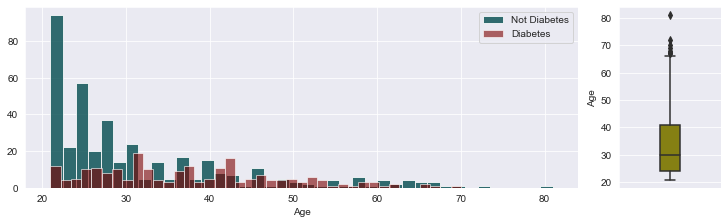

In [22]:
plots("Age")

Ada beberapa pengukuran di atas UW karena kejadian langka. Kami menggantinya dengan kuantit ke-95.

In [23]:
q95th = train_X["Age"].quantile(0.95)
Q1 = train_X["Age"].quantile(0.25)
Q3 = train_X["Age"].quantile(0.75)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR

train_X["Age"] = np.where(train_X["Age"] > UW,
                          q95th, train_X["Age"])

## Standardization

Untuk meningkatkan kinerja pembelajaran, fitur input distandarisasi. Rata-rata dan simpangan baku fitur dihitung. Kemudian, rata-rata dikurangi dari setiap sampel fitur dan hasilnya dibagi dengan simpangan baku. Tujuannya adalah untuk mengubah fitur agar memiliki rata-rata 0 dan simpangan baku 1. **StandardScaler** dari **scikit-learn** digunakan. A **StandardScaler** cocok dengan fitur di **train_X**, maka scaler ini mengubah fitur yang sama di **train_X** dan **test_X**.

In [24]:
feature_names = train_X.columns

scaler = StandardScaler()

# fit to train_X
scaler.fit(train_X)

# transform train_X
train_X = scaler.transform(train_X)
train_X = pd.DataFrame(train_X, columns = feature_names)

# transform test_X
test_X = scaler.transform(test_X)
test_X = pd.DataFrame(test_X, columns = feature_names)

## Correlation Analysis

Korelasi linear antara fitur dan juga antara fitur dan output dihitung. ** Pandas corr** fungsi digunakan untuk menghitung matriks korelasi dan ** Seaborn heatmap ** digunakan untuk merencanakan.

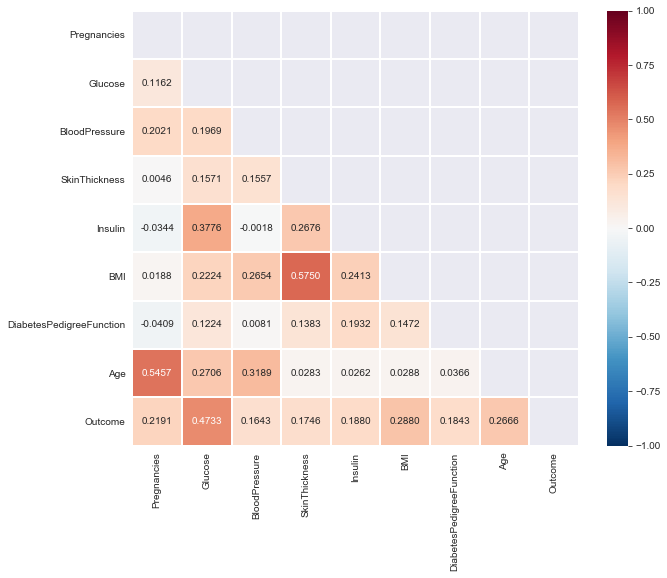

In [25]:
corr_matrix = pd.concat([train_X, train_Y], axis=1).corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))

plt.figure(figsize=(10,8))
sea.heatmap(corr_matrix,annot=True, fmt=".4f",
            vmin=-1, vmax=1, linewidth = 1,
            center=0, mask=mask,cmap="RdBu_r");

Matriks korelasi menunjukkan bahwa ada korelasi ringan antara **SkinThickness-BMI** dan **Age-Pregnancies**. **Outcome** memiliki korelasi linier tertinggi dengan **Glukosa**.

## Feature Importance


Metode analisis penting fitur dapat dibagi menjadi 3 kategori luas:

* Filter method: Menghitung metrik seperti koefisien korelasi antara setiap fitur dan output secara terpisah seperti yang kami lakukan di atas. Dalam metode ini semua fitur dievaluasi secara independen.

* Embedded method: Metode seperti regresi logistik atau regresi linier mempelajari koefisien yang mengalikan setiap fitur. Besarnya koefisien dikaitkan dengan pentingnya fitur. Juga, metode berbasis pohon seperti hutan acak atau pohon gradien yang meningkatkan fitur belajar penting selama proses pelatihan. Dalam metode yang disematkan, semua fitur dievaluasi bersama.

* Wrapper methods: Pada dasarnya Anda memiliki estimator dan Anda melatih estimator ini dengan subset fitur. Subset yang memberikan skor terbaik dipilih dan fitur lainnya dihilangkan.

In [26]:
# logistic regression with l1 penalty - embedded method
lr1 = LogisticRegression(random_state=0, penalty="l1",
            class_weight="balanced", solver="saga", max_iter=5000)
lr1.fit(train_X, train_Y.values.ravel())

lr1.coef_

array([[ 3.60358322e-01,  1.06754141e+00, -2.50971359e-02,
        -9.81326043e-05, -6.49737080e-02,  5.74505582e-01,
         3.35113887e-01,  2.71385240e-01]])

In [27]:
# logistic regression with l2 penalty - embedded method
lr2 = LogisticRegression(random_state=0, penalty="l2",
            class_weight="balanced", solver="saga", max_iter=5000)
lr2.fit(train_X, train_Y.values.ravel())

lr2.coef_

array([[ 0.36506112,  1.07199682, -0.04073014, -0.01616834, -0.07560637,
         0.59537491,  0.34399744,  0.28125417]])

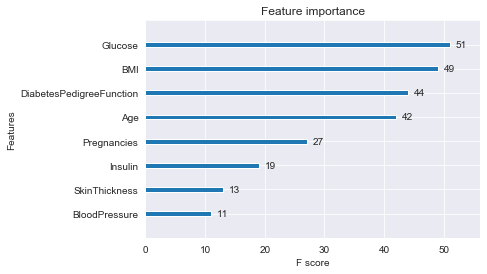

In [28]:
# xgboost - embedded method
gb = xgb.XGBClassifier(booster="gbtree",
                      learning_rate=0.15,
                      max_depth=4,
                      n_estimators=20,
                      random_state=0)
gb.fit(train_X, train_Y.values.ravel())

plot_importance(gb);

In [29]:
# recursive feature elimination with logistic regression - wrapper method
lr3 = LogisticRegression(random_state=0, penalty="l2",
            class_weight="balanced", solver="saga", max_iter=5000)
rfe_lr3 = RFE(lr3, n_features_to_select=7)
rfe_lr3.fit(train_X, train_Y.values.ravel())

print(rfe_lr3.support_)

[ True  True  True False  True  True  True  True]


Tiga analisis pertama menandai BloodPressure, SkinThickness dan Insulin sebagai fitur yang paling tidak penting. Perhatikan bahwa fitur-fitur ini memiliki korelasi yang sangat rendah dengan Outcome. RFE menandai SkinThickness sebagai yang paling tidak penting.

In [30]:
train_X.drop("SkinThickness", axis=1, inplace=True)
test_X.drop("SkinThickness", axis=1, inplace=True)

## Train MLP

MLPClassifier dengan single hidden layer yang digunakan untuk prediksi diabetes.

In [31]:
clf = MLPClassifier(solver="adam", max_iter=5000, activation = "relu",
                    hidden_layer_sizes = (12),                      
                    alpha = 0.01,
                    batch_size = 64,
                    learning_rate_init = 0.001,
                    random_state=2)

clf.fit(train_X, train_Y.values.ravel());

## Test MLP

In [33]:
print(classification_report(test_Y, clf.predict(test_X),
                            digits = 4,
                            target_names=["Not Diabetes",
                                          "Diabetes"]))

              precision    recall  f1-score   support

Not Diabetes     0.8624    0.9400    0.8995       100
    Diabetes     0.8667    0.7222    0.7879        54

    accuracy                         0.8636       154
   macro avg     0.8645    0.8311    0.8437       154
weighted avg     0.8639    0.8636    0.8604       154



Kesimpulan:
dapat disimpulkan bahwa presisi orang yang tidak terkena diabetes adalah 0.8624, recall 0.94 f1-score 0,8995 dengan support 100. sedangkan dengan yang terkena diabetes adalah presisi 0.8667, recall 0.7222 f1-score 0.7879 dengan support 54.